In [1]:
# author: Lino Grossano lino.grossano@gmail.com
# author: Stefano Manzini stefano.manzini@gmail.com
from PIL import Image
from pathlib import Path

In [20]:
def load_pic(
    image_name = "wallhaven-g78rvl.jpg",
    folder_name = "imgs_to_crop"
    ):
    
    fullpath = Path(folder_name, image_name)
    picture = Image.open(fullpath)
    return picture


def crop_in_tiles(
    image, tile_size=28, shift=0
    ):
    
    """
    this function crops an image in several tiles; every tile
    is a square of *tile_size* pixels. *shift* = 0 crops the image
    from coordinates (0,0), while *shift* = tile_size/2
    (or other values) crops tiles that overlaps edges.
    Every set of tiles is saved in a separate folder.
    """
    
    width, height = image.size

    #create folder for set of tile
    # *debug*: questo è utile solo alla definizione del filename di dest
    if shift == 0:
        shift_type = 'SHIFT0' #crop that begins at x=0, y=0
    else:
        shift_type = 'SHIFT1' #crop shifted of a precise amount of pixels
        
    folder = Path(image_name.replace('.jpg', '') + shift_type)
    folder.mkdir(exist_ok=True) #skip errors if folder already exists
    storing_folder = str(folder)

    #calculate coordinates of every tile
    for x in range (0+shift, width, tile_size):
        for y in range (0+shift, height, tile_size):
            tile_coord = (
                x, y,
                x + tile_size if x + tile_size < width else width - 1, # perchè -1? è suff?
                y + tile_size if y + tile_size < height else height - 1
            )
        
            #crop in tiles, save in relative folder        
            image.crop(tile_coord).save(storing_folder + f'/%s_x%04d_y%04d_{shift_type}.jpg' % (image_name.replace('.jpg', ''), x, y)) #takes the image, crops it at the given coordinates, saves it in the relative folder
    
#execute 2 sets of cropping: starting at x, y = 0, and with a shift of 14 pixels            
#crop_in_tiles(picture, tile_size, 0)            
#crop_in_tiles(picture, tile_size, 14)


In [19]:
pic.filename

'/Users/manz/Downloads/crop_tiles/imgs_to_crop/wallhaven-g78rvl.jpg'

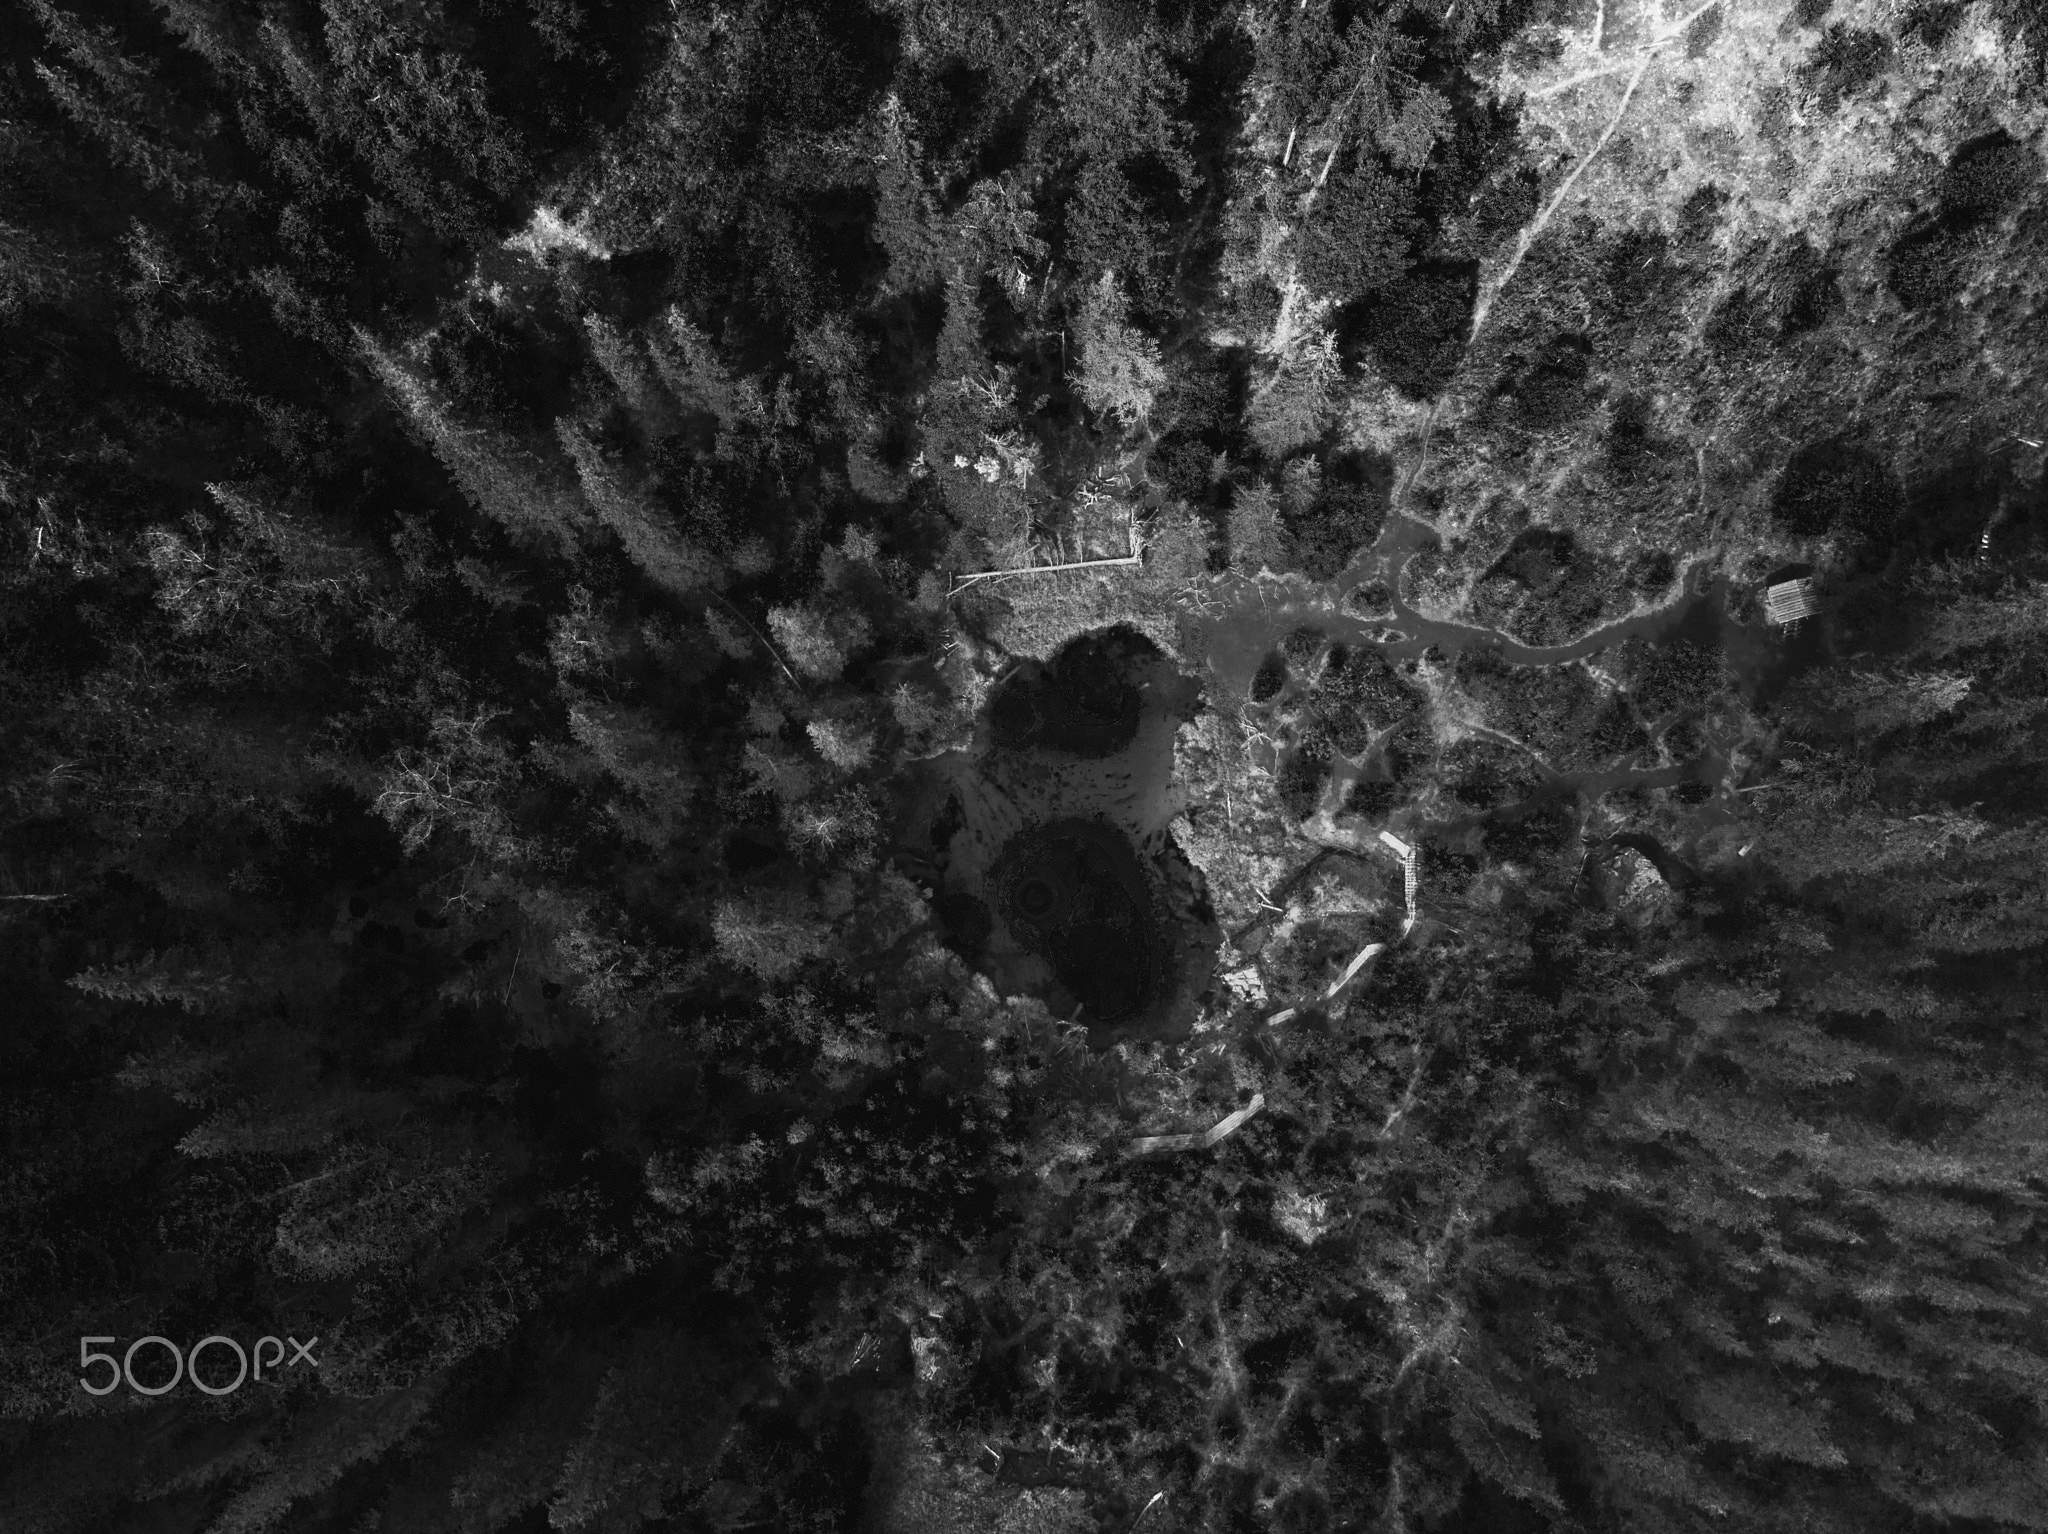

In [18]:
pic.getchannel("R")